# Imagenet Processing in parallel

In [2]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/jhoward/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from bcolz_array_iterator import BcolzArrayIterator

In [4]:
limit_mem()

This is where our full dataset lives. It's slow spinning discs, but lots of room!

**NB:** We can easily switch to and from using a sample. We'll use a sample for *everything*, except the final complete processing (which we'll use fast/expensive compute for, and time on the sample so we know how long it will take).

In [4]:
path = '/data/jhoward/imagenet/full/'
# path = '/data/jhoward/imagenet/sample/'

This is on a RAID 1 SSD for fast access, so good for resized images and feature arrays

In [5]:
dpath = '/data/jhoward/fast/imagenet/full/'
# dpath = '/data/jhoward/fast/imagenet/sample/'
# %mkdir {dpath}

Note that either way, AWS isn't going to be a great place for doing this kind of analysis - putting a model into production will cost at minimum $600/month for a P2 instance. For that price you can **buy** a GTX 1080 card, which has **double** the performance of the AWS P2 card! And you can set up your slow full data RAID 5 array and your fast preprocessed data RAID 1 array just as you like it. Since you'll want your own servers for production, you may as well use them for training, and benefit from the greater speed, lower cost, and greater control of storage resources.

You can put your server inside a colo facility for very little money, paying just for the network and power. (Cloud providers aren't even allowed to provide GTX 1080's!)

There's little need for distributed computing systems for the vast majority of training and production needs in deep learning.

## Get word vectors

First we need to grab some word vectors, to use as our dependent variable for the image model (so that the image vectors and word vectors will be in the same space). After loading the word vectors, we'll make sure that the names of the wordnet/imagenet are in the word list.

* Be careful not to just follow paper's approach - e.g. here word2vec better than custom wikipedia vectors. word2vec has multi-word tokens like 'golden retriever'
* Take evaluations shown in papers with a grain of salt, and do your own tests on important bits. E.g. DeVISE (because it's an older paper) used an old and inaccurate image model, and poor word vectors, so recent papers that compare to it aren't so relevent

In [83]:
from gensim.models import word2vec
w2v_path='/data/jhoward/datasets/nlp/GoogleNews-vectors-negative300'

In [87]:
model = word2vec.Word2Vec.load_word2vec_format(w2v_path+'.bin', binary=True)
model.save_word2vec_format(w2v_path+'.txt', binary=False)

In [88]:
lines = open(w2v_path+'.txt').readlines()

In [89]:
def parse_w2v(l):
    i=l.index(' ')
    return l[:i], np.fromstring(l[i+1:-2], 'float32', sep=' ')

In [90]:
w2v_list = list(map(parse_w2v, lines[1:]))

In [91]:
pickle.dump(w2v_list, open(path+'../w2vl.pkl', 'wb'))

In [6]:
w2v_list = pickle.load(open(path+'../w2vl.pkl', 'rb'))

We save the processed file so we can access it quickly in the future. It's a good idea to save any intermediate results that take a while to recreate, so you can use them both in production and prototyping.

In [7]:
w2v_dict = dict(w2v_list)
words,vectors = zip(*w2v_list)

Always test your inputs! If you're not sure what to look for, try to come up with some kind of reasonableness test.

In [8]:
np.corrcoef(w2v_dict['jeremy'], w2v_dict['Jeremy'])

array([[ 1.        ,  0.16497618],
       [ 0.16497618,  1.        ]])

In [9]:
np.corrcoef(w2v_dict['banana'], w2v_dict['Jeremy'])

array([[ 1.        ,  0.01871472],
       [ 0.01871472,  1.        ]])

In [10]:
lc_w2v = {w.lower(): w2v_dict[w] for w in reversed(words)}

We're going to map word vectors for each of:
* The 1000 categories in the Imagenet competition
* The 82,000 nouns in Wordnet

In [11]:
fpath = get_file('imagenet_class_index.json', 
                 'http://www.platform.ai/models/imagenet_class_index.json', 
                 cache_subdir='models')
class_dict = json.load(open(fpath))
nclass = len(class_dict); nclass

1000

In [12]:
classids_1k = dict(class_dict.values())
classid_lines = open(path+'../classids.txt', 'r').readlines()
classids = dict(l.strip().split(' ') for l in classid_lines)
len(classids)

82115

In [13]:
syn_wv = [(k, lc_w2v[v.lower()]) for k,v in classids.items()
          if v.lower() in lc_w2v]
syn_wv_1k = [(k, lc_w2v[v.lower()]) for k,v in classids_1k.items()
          if v.lower() in lc_w2v]
syn2wv = dict(syn_wv); len(syn2wv)

51633

In [14]:
nomatch = [v[0] for v in class_dict.values() if v[0] not in syn2wv]

In [15]:
# nm_path=path+'train_nm/'
# os.mkdir(nm_path)
# for nm in nomatch: os.rename(path+'train/'+nm, nm_path+nm)

In [16]:
ndim = len(list(syn2wv.values())[0]); ndim

300

## Resize images

Now that we've got our word vectors, we need a model that can create image vectors. It's nearly always best to start with a pre-train image model, and these require a specific size input. We'll be using resnet, which requires 224x224 sized images. Reading jpegs and resizing them can be slow, so we'll store the result of this.

First we create the filename list for the imagenet archive:

In [102]:
fnames = list(glob.iglob(path+'train/*/*.JPEG'))
pickle.dump(fnames, open(path+'fnames.pkl', 'wb'))

Even scanning a large collection of files is slow, so we save the filenames:

In [18]:
fnames = pickle.load(open(path+'fnames.pkl', 'rb'))

In [19]:
fnames = np.random.permutation(fnames)

In [21]:
pickle.dump(fnames, open(path+'fnames_r.pkl', 'wb'))

In [6]:
fnames = pickle.load(open(path+'fnames_r.pkl', 'rb'))

In [14]:
new_s = 72 # height and width to resize to
n = len(fnames); n

996433

In [15]:
bc_path = f'{dpath}/trn_resized_{new_s}_r.bc'

Using pillow to resize the image (recommendation: install pillow-simd for 600% speedup). To install, force remove the conda installed version, then:

    CC="cc -mavx2" pip install -U --force-reinstall pillow-simd

In [9]:
def _resize(img):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

In [10]:
def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: 
        return
    return _resize(img)

In [1]:
def resize_img_bw(i):
    return _resize(Image.open(fnames[i]).convert('L'))

Pre-allocate memory in threadlocal storage

In [19]:
tl = threading.local()

In [20]:
tl.place = np.zeros((new_s,new_s,3), 'uint8')
#tl.place = np.zeros((new_s,new_s), 'uint8')

Bcolz is amazingly fast, easy to use, and provides a largely numpy-compatible interface. It creates file-backed arrays and are transparently cached in memory.

Create (or open) compressed array for our resized images

In [21]:
arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), 
                   chunklen=32, mode='w', rootdir=bc_path)

Function that appends resized image with black border added to longer axis

In [17]:
def get_slice(p, n): 
    return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    tl.place[:] = (np.array(r)[get_slice(r.size[1],new_s), get_slice(r.size[0],new_s)] 
        if r else 0.)
    arr.append(tl.place)

In [241]:
# Serial version
for i in range(2000): 
    app_img(resize_img(i))
arr.flush()

In [ ]:
# Parallel version
step=6400
for i in range(0, n, step):
    with ThreadPoolExecutor(max_workers=16) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res: app_img(r)
    arr.flush()

Times to process 2000 images that aren't in filesystem cache (tpe==ThreadPoolExecutor, ppe==ProcessPoolExecutor; number shows #jobs)

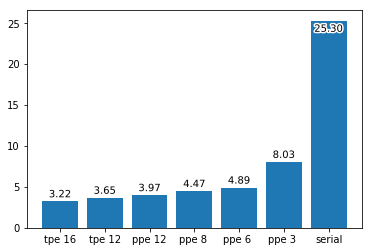

In [115]:
times = [('tpe 16', 3.22), ('tpe 12', 3.65), ('ppe 12', 3.97), ('ppe 8 ', 4.47), 
         ('ppe 6 ', 4.89), ('ppe 3 ', 8.03), ('serial', 25.3)]

column_chart(*zip(*times))

In [40]:
arr = bcolz.open(bc_path)

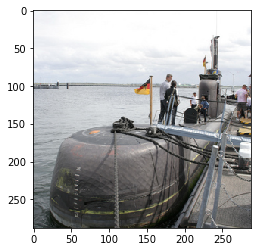

In [41]:
plt.imshow(arr[-2].astype('uint8'))

We do our prototyping in a notebook, and then use *'Download as->Notebook'* to get a python script we can run under tmux. Notebooks are great for running small experiments, since it's easy to make lots of changes and inspect the results in a wide variety of ways.

## Create model

Now we're ready to create our first model. Step one: create our target labels, which is simply a case of grabbing the synset id from the filename, and looking up the word vector for each.

In [21]:
def get_synset(f): return f[f.rfind('/')+1:f.find('_')]

labels = list(map(get_synset, fnames))
labels[:5]

['n01580077', 'n02098413', 'n03947888', 'n07717410', 'n02802426']

In [22]:
vecs = np.stack([syn2wv[l] for l in labels]); vecs.shape

(996433, 300)

We'll be using resnet as our model for these experiments.

In [22]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
inp = Input((224,224,3))
preproc = Lambda(lambda x: (x - rn_mean)[:, :, :, ::-1])(inp)
model = ResNet50(include_top=False, input_tensor=preproc)

In order to make each step faster, we'll save a couple of intermediate activations that we'll be using shortly. First, the last layer before the final convolutional bottleneck:

In [27]:
mid_start = model.get_layer('res5a_branch2a')
mid_out = model.layers[model.layers.index(mid_start)-1]
mid_out.output_shape

(None, 14, 14, 1024)

We put an average pooling layer on top to make it a more managable size.

In [28]:
rn_top = Model(model.input, mid_out.output)
rn_top_avg = Sequential([rn_top, AveragePooling2D((7,7))])
shp=rn_top_avg.output_shape; shp

(None, 2, 2, 1024)

We create this intermediate array a batch at a time, so we don't have to keep it in memory.

In [23]:
features_mid = bcolz.open(path+'results/features_mid_1c_r.bc')

In [34]:
features_mid = bcolz.carray(np.empty((0,)+shp[1:]), rootdir=path+'results/features_mid_1c_r.bc',
                           chunklen=32, mode='w')

In [86]:
def gen_features_mid(dirn):
    gen = (arr[i:min(i+128,n)] for i in range(0, len(arr), 128))
    for i,batch in enumerate(gen):
        features_mid.append(rn_top_avg.predict_on_batch(batch[:,:,:,::dirn]))
        if (i%100==99):
            features_mid.flush()
            print(i)
    features_mid.flush()

In [ ]:
gen_features_mid(1)

In [87]:
gen_features_mid(-1)

99
199
299
399
499
599
699
799
899
999
1099
1199
1299
1399
1499
1599
1699
1799
1899
1999
2099
2199
2299
2399
2499
2599
2699
2799
2899
2999
3099
3199
3299
3399
3499
3599
3699
3799
3899
3999
4099
4199
4299
4399
4499
4599
4699
4799
4899
4999
5099
5199
5299
5399
5499
5599
5699
5799
5899
5999
6099
6199
6299
6399
6499
6599
6699
6799
6899
6999
7099
7199
7299
7399
7499
7599
7699


In [24]:
features_mid.shape

(1992866, 2, 2, 1024)

Our final layers match the original resnet, although we add on extra resnet block at the top as well.

In [29]:
rn_bot_inp = Input(shp[1:])
x = rn_bot_inp
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
x = Flatten()(x)
rn_bot = Model(rn_bot_inp, x)
rn_bot.output_shape

(None, 2048)

In [30]:
for i in range(len(rn_bot.layers)-1):
    rn_bot.layers[-i-2].set_weights(model.layers[-i-2].get_weights())

We save this layer's results too, although it's smaller so should fit in RAM.

In [90]:
%time features_last = rn_bot.predict(features_mid, batch_size=128)

CPU times: user 5min 47s, sys: 2min 46s, total: 8min 34s
Wall time: 6min 42s


In [91]:
features_last = bcolz.carray(features_last, rootdir=path+'results/features_last_r.bc', 
                             chunklen=64, mode='w')

In [31]:
features_last = bcolz.open(path+'results/features_last_r.bc')[:]

We add a linear model on top to predict our word vectors.

In [32]:
lm_inp = Input(shape=(2048,))
lm = Model(lm_inp, Dense(ndim)(lm_inp))

cosine distance is a good choice for anything involving nearest neighbors (which we'll use later).

In [33]:
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(1 - K.sum((y_true * y_pred), axis=-1))

In [34]:
lm.compile('adam',cos_distance)

In [98]:
v = np.concatenate([vecs, vecs])

In [100]:
lm.evaluate(features_last, v, verbose=0)

0.98340248721806178

In [101]:
lm.fit(features_last, v, verbose=2, nb_epoch=4)

Epoch 1/4
223s - loss: 0.5304
Epoch 2/4
222s - loss: 0.5250
Epoch 3/4
222s - loss: 0.5240
Epoch 4/4
221s - loss: 0.5234


Be sure to save intermediate weights, to avoid recalculating them

In [88]:
lm.save_weights(path+'results/lm_cos.h5')

In [36]:
lm.load_weights(path+'results/lm_cos.h5')

## Nearest Neighbors

Let's use nearest neighbors to look at a couple of examples, to see how well it's working. The first NN will be just looking at the word vectors of the 1,000 imagenet competition categories.

In [46]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

In [104]:
nn = NearestNeighbors(3, metric='cosine', algorithm='brute').fit(wvs)

In [47]:
nn = LSHForest(20, n_neighbors=3).fit(wvs)

In [106]:
%time pred_wv = lm.predict(features_last[:10000])

CPU times: user 1.9 s, sys: 100 ms, total: 2 s
Wall time: 800 ms


In [107]:
%time dist, idxs = nn.kneighbors(pred_wv)

CPU times: user 2min 49s, sys: 2.08 s, total: 2min 51s
Wall time: 28.5 s


In [108]:
[[classids[syns[id]] for id in ids] for ids in idxs[190:200]]

[['trombone', 'flute', 'cello'],
 ['altar', 'triumphal_arch', 'stupa'],
 ['flute', 'maraca', 'lampshade'],
 ['crib', 'bassinet', 'china_cabinet'],
 ['barometer', 'stopwatch', 'magnetic_compass'],
 ['Irish_wolfhound', 'Border_terrier', 'Tibetan_terrier'],
 ['remote_control', 'joystick', 'espresso_maker'],
 ['Samoyed', 'miniature_poodle', 'Great_Pyrenees'],
 ['baseball', 'garter_snake', 'sock'],
 ['Granny_Smith', 'lemon', 'bee_eater']]

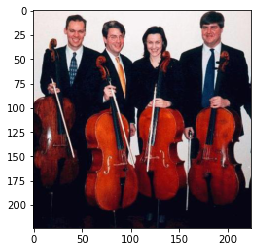

In [109]:
plt.imshow(arr[190].astype('uint8'))

A much harder task is to look up every wordnet synset id.

In [53]:
all_syns, all_wvs = list(zip(*syn_wv))
all_wvs = np.array(all_wvs)

In [54]:
all_nn = LSHForest(20, n_neighbors=3).fit(all_wvs)

In [112]:
%time dist, idxs = all_nn.kneighbors(pred_wv[:200])

CPU times: user 18.3 s, sys: 300 ms, total: 18.6 s
Wall time: 3.1 s


In [113]:
[[classids[all_syns[id]] for id in ids] for ids in idxs[190:200]]

[['trombone', 'piano', 'piano'],
 ['cathedra', 'rood_screen', 'chancel'],
 ['pinecone', 'dishpan', 'reindeer_moss'],
 ['crib', 'crib', 'crib'],
 ['barometer', 'indicator', 'indicator'],
 ['Irish_wolfhound', 'standard_poodle', 'horned_owl'],
 ['suction_cup', 'pyrometer', 'hex_nut'],
 ['Samoyed', 'Samoyed', 'miniature_poodle'],
 ['isopod', 'spadix', 'staghorn_fern'],
 ['deutzia', 'Brugmansia', 'crookneck']]

## Fine tune

To improve things, let's fine tune more layers.

In [37]:
lm_inp2 = Input(shape=(2048,))
lm2 = Model(lm_inp2, Dense(ndim)(lm_inp2))

In [38]:
for l1,l2 in zip(lm.layers,lm2.layers): l2.set_weights(l1.get_weights())

In [39]:
rn_bot_seq = Sequential([rn_bot, lm2])
rn_bot_seq.compile('adam', cos_distance)
rn_bot_seq.output_shape

(None, 300)

In [40]:
bc_it = BcolzArrayIterator(features_mid, v, shuffle=True, batch_size=128)

In [41]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-3)

In [42]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose=2, nb_epoch=15)

Epoch 1/15
870s - loss: 0.3195
Epoch 2/15
870s - loss: 0.2396
Epoch 3/15
870s - loss: 0.2138
Epoch 4/15
871s - loss: 0.1981
Epoch 5/15
871s - loss: 0.1865
Epoch 6/15
870s - loss: 0.1774
Epoch 7/15
871s - loss: 0.1703
Epoch 8/15
871s - loss: 0.1644
Epoch 9/15
870s - loss: 0.1590
Epoch 10/15
871s - loss: 0.1546
Epoch 11/15
872s - loss: 0.1504
Epoch 12/15
871s - loss: 0.1468
Epoch 13/15
870s - loss: 0.1438
Epoch 14/15
871s - loss: 0.1406
Epoch 15/15


KeyboardInterrupt: 

In [70]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-4)

In [71]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose=2, nb_epoch=5)

Epoch 1/5
872s - loss: 0.1237
Epoch 2/5


/home/jhoward/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


871s - loss: 0.1147
Epoch 3/5
871s - loss: 0.1119
Epoch 4/5
870s - loss: 0.1092
Epoch 5/5
871s - loss: 0.1076


In [72]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-5)

In [73]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose=2, nb_epoch=2)

Epoch 1/2
871s - loss: 0.1059
Epoch 2/2
871s - loss: 0.1051


/home/jhoward/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [208]:
beep()

In [ ]:
rn_bot_seq.evaluate(features_mid, vecs, verbose=2)

In [87]:
rn_bot_seq.save_weights(path+'results/rn_bot_seq_cos.h5')

In [50]:
rn_bot_seq.load_weights(path+'results/rn_bot_seq_cos.h5')

## KNN again

In [74]:
%time pred_wv = rn_bot_seq.predict(features_mid)

CPU times: user 18min 20s, sys: 2min 44s, total: 21min 4s
Wall time: 9min 39s


In [44]:
rng = slice(190,200)

In [48]:
dist, idxs = nn.kneighbors(pred_wv[rng])

In [49]:
[[classids[syns[id]] for id in ids] for ids in idxs]

[['cello', 'violin', 'bassoon'],
 ['throne', 'monarch', 'pedestal'],
 ['harmonica', 'banjo', 'acoustic_guitar'],
 ['crib', 'bassinet', 'cradle'],
 ['barometer', 'punching_bag', 'monitor'],
 ['porcupine', 'bullfrog', 'ptarmigan'],
 ['remote_control', 'espresso_maker', 'CD_player'],
 ['Arctic_fox', 'redshank', 'colobus'],
 ['baseball', 'ballplayer', 'volleyball'],
 ['goldfinch', 'brambling', 'partridge']]

In [55]:
dist, idxs = all_nn.kneighbors(pred_wv[rng])

In [56]:
[[classids[all_syns[id]] for id in ids] for ids in idxs]

[['cello', 'violin', 'clarinet'],
 ['throne', 'throne', 'heir_presumptive'],
 ['harmonica', 'guitar', 'tambourine'],
 ['crib', 'crib', 'crib'],
 ['barometer', 'indicator', 'indicator'],
 ['porcupine', 'Sudbury', 'Salmo'],
 ['remote_control', 'operating_system', 'joystick'],
 ['Arctic_fox', 'bettong', 'bushbuck'],
 ['baseball', 'baseball', 'football'],
 ['goldfinch', 'birch', 'birch']]

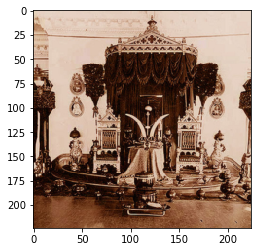

In [52]:
plt.imshow(arr[rng][1].astype('uint8'))

## Text -> Image

Something very nice about this kind of model is we can go in the other direction as well - find images similar to a word or phrase!

In [75]:
img_nn = NearestNeighbors(3, metric='cosine', algorithm='brute').fit(pred_wv)

In [82]:
word = 'violin'
vec = w2v_dict[word]
dist, idxs = img_nn.kneighbors(vec.reshape(1,-1))

In [77]:
img_nn2 = LSHForest(20, n_neighbors=3).fit(pred_wv)

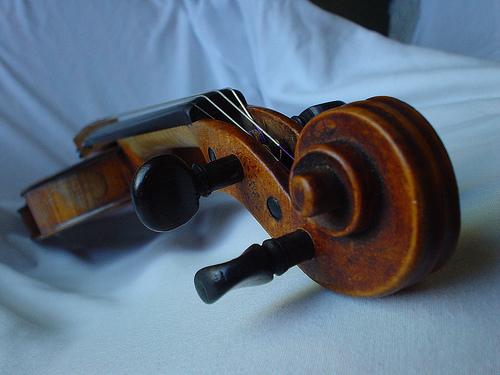

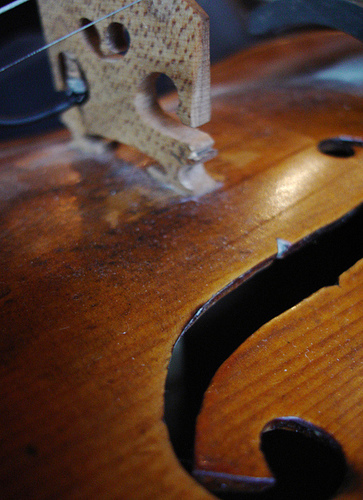

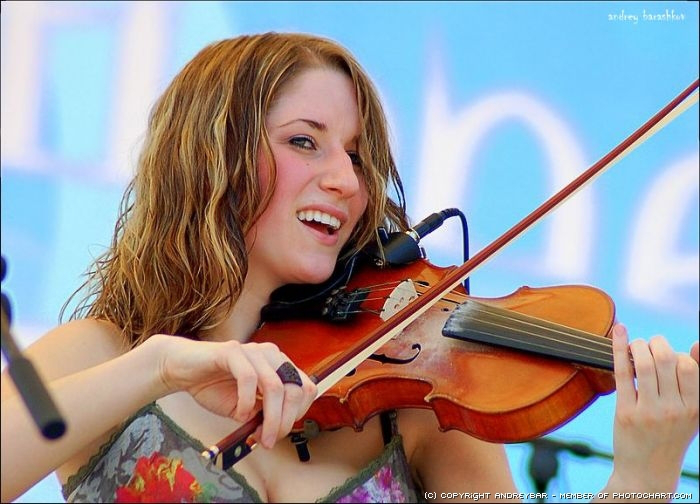

In [83]:
dist, idxs = img_nn2.kneighbors(vec.reshape(1,-1))
ims = [Image.open(fnames[fn%n]) for fn in idxs[0]]
display(*ims)

## Image -> image

Since that worked so well, let's try to find images with similar content to another image...

In [62]:
ft_model = Sequential([rn_top_avg, rn_bot_seq])

In [63]:
new_file = '/data/jhoward/imagenet/full/valid/n01498041/ILSVRC2012_val_00005642.JPEG'

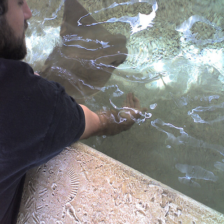

In [64]:
new_im = Image.open(new_file).resize((224,224), Image.BILINEAR); new_im

In [84]:
vec = ft_model.predict(np.expand_dims(new_im, 0))

In [85]:
dist, idxs = img_nn2.kneighbors(vec)

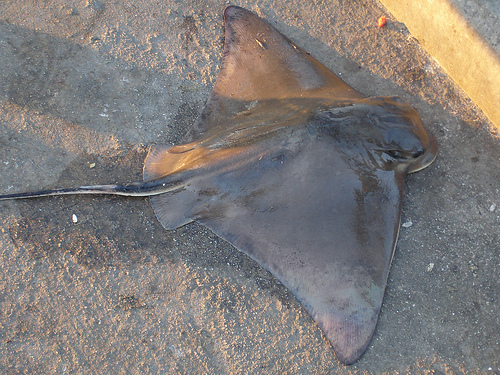

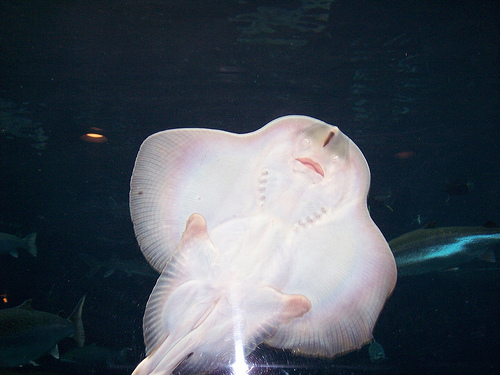

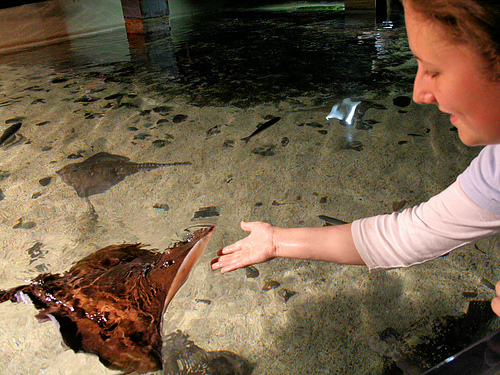

In [84]:
ims = [Image.open(fnames[fn]) for fn in idxs[0]]
display(*ims)